# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.2 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [7]:
# Load libraries and environment
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
from collections import deque

from dqn_agent import Agent

import matplotlib.pyplot as plt
%matplotlib inline
# please do not modify the line below

from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [8]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment. At each time step, it has four actions at its disposal:

- 0 - walk forward
- 1 - walk backward
- 2 - turn left
- 3 - turn right

The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction. A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana.

Run the code cell below to print some information about the environment.

In [9]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [10]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


You have watched the agent's performance without training: It selects an action at random with each time step, the final score is pretty low because every action is random.

We will show later after training, the performance will increase dramatically.

### 4. Using DQN to train the agent



Train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [11]:
# now define the dqn function to be able to use deep learning to train the agent
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,ckpt_path='checkpoints/checkpoint.pth'):
    """Deep Q-Learning.
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    avgs_score = []                   # save to a list
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0  # initialize the score
        
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        avgs_scoret = np.mean(scores_window)  # calculate moving average
        avgs_score.append(avgs_scoret)       # save most recent moving average
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        if avgs_scoret>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), ckpt_path)
            break
    return scores, avgs_score

###  4.1. Start training,  try different training parameter first

Episode 100	Average Score: 0.70
Episode 200	Average Score: 4.14
Episode 300	Average Score: 7.14
Episode 400	Average Score: 10.94
Episode 500	Average Score: 12.68
Episode 506	Average Score: 13.12
Environment solved in 406 episodes!	Average Score: 13.12

Total Training time = 10.7 min


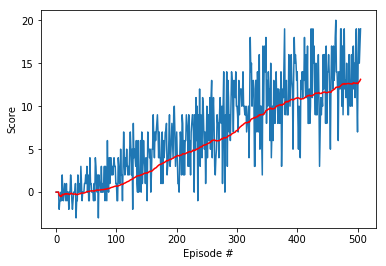

In [34]:
# Test 1
start_time = time.time()
agent = Agent(state_size=37, action_size=4, seed=0)
scores,avgs = dqn(n_episodes=600,eps_start=1.0, eps_end=0.01, eps_decay=0.995, ckpt_path='pth_checkpoints/Test1_checkpoint.pth')
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

# plot the scores
fig = plt.figure()
plt.plot(np.arange(len(scores)), scores,label='Test1')
plt.plot(np.arange(len(scores)), avgs, c='r', label='averaged score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 1.23
Episode 200	Average Score: 5.62
Episode 300	Average Score: 10.67
Episode 397	Average Score: 13.00
Environment solved in 297 episodes!	Average Score: 13.00

Total Training time = 8.3 min


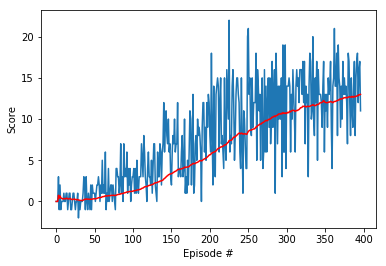

In [32]:
# Test 2 change the decay rate
start_time = time.time()
agent = Agent(state_size=37, action_size=4, seed=0)
scores,avgs = dqn(n_episodes=600, eps_decay=0.98, eps_end=0.02, ckpt_path='pth_checkpoints/Test2_checkpoint.pth')
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

# plot the scores
fig = plt.figure()
plt.plot(np.arange(len(scores)), scores,label='Test2')
plt.plot(np.arange(len(scores)), avgs, c='r', label='averaged score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 3.16
Episode 200	Average Score: 8.11
Episode 300	Average Score: 11.82
Episode 341	Average Score: 13.04
Environment solved in 241 episodes!	Average Score: 13.04

Total Training time = 7.2 min


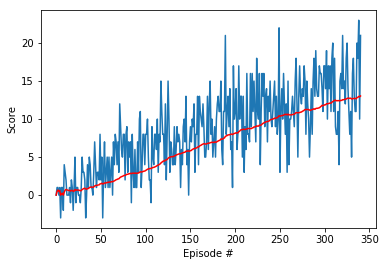

In [35]:
# Test 3
start_time = time.time()
agent = Agent(state_size=37, action_size=4, seed=0)
scores,avgs = dqn(n_episodes=600,max_t=1000, eps_start=1.0, eps_end=0.03,eps_decay=0.95, ckpt_path='pth_checkpoints/Test3_checkpoint.pth')
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

# plot the scores
fig = plt.figure()
plt.plot(np.arange(len(scores)), scores,label='Test3')
plt.plot(np.arange(len(scores)), avgs, c='r', label='averaged score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### It seems decay rate can affect how fast we can get to 13 score 

###  4.2. Can also chnage the model parameters to improve the training

Episode 100	Average Score: 3.52
Episode 200	Average Score: 8.16
Episode 300	Average Score: 11.81
Episode 341	Average Score: 13.08
Environment solved in 241 episodes!	Average Score: 13.08

Total Training time = 7.6 min


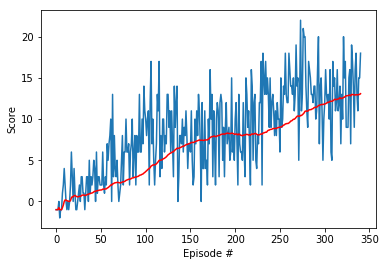

In [12]:
# change to three layer MPL
# Test 4
start_time = time.time()
agent = Agent(state_size=37, action_size=4, seed=0)
scores,avgs = dqn(n_episodes=600,max_t=1000, eps_start=1.0, eps_end=0.03,eps_decay=0.95, ckpt_path='pth_checkpoints/Test4_checkpoint.pth')
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

# plot the scores
fig = plt.figure()
plt.plot(np.arange(len(scores)), scores,label='Test4')
plt.plot(np.arange(len(scores)), avgs, c='r', label='averaged score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### It seems Adding one layer doesn't improve the number of episodes to get to score =13, and it takes slightly longer 

### 4.3  load the trained agent and then play

In [27]:
cwd = os.getcwd()
print(cwd)

/home/workspace


In [10]:
agent = Agent(state_size=37, action_size=4, seed=0)
agent.qnetwork_local.load_state_dict(torch.load('pth_checkpoints/Test3_checkpoint.pth'))

In [16]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state, eps=0)         # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 9.0


Score: 8.0


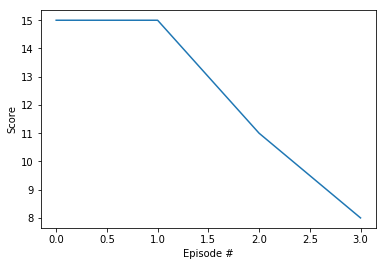

In [17]:
scores=[]
for i in range(1,5):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0 
    while True:
        action = (int)(agent.act(state,0.01))          # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:
            scores.append(score)# exit loop if episode finished
            break
    
print("Score: {}".format(score))

# plot the scores
fig = plt.figure()
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [13]:
env.close()